# 性能测试：LM单步IK求解

## 1. 导入库和初始化

In [12]:
import numpy as np
import time
import matplotlib.pyplot as plt
from typing import Tuple

# 设置中文字体
plt.rcParams['font.sans-serif'] = ['SimHei', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False

# 导入机器人模型
from ik.robot import create_so101_5dof
from ik.utils import angle_axis

print("✓ 库导入成功")

✓ 库导入成功


## 2. Python 参考实现: LM 单步计算

实现与硬件相同的功能: 从 sin/cos/error/lambda 计算 delta_q

In [18]:
class PythonLMSingleStep:
    """
    Python 实现的 LM 单步迭代器
    
    模拟硬件加速器的功能:
    输入: sin_q[5], cos_q[5], error[6], lambda
    输出: delta_q[5]
    
    算法: delta_q = (J^T * We * J + λI)^{-1} * J^T * We * e
    """
    
    def __init__(self, robot):
        """
        初始化 Python LM 单步求解器
        
        Args:
            robot: SO101 机器人模型 (用于获取 DH 参数)
        """
        self.robot = robot
        self.n = 5  # 关节数
        
        # SO101 DH 参数 (从 robot.py 提取)
        # 这些是用于雅可比矩阵计算的连杆参数
        self.d = np.array([0.0598, 0.05504, 0.1127, 0.00519, 0.00996], dtype=np.float32)
        self.a = np.array([0.0612, 0.02943, 0.02798, 0.15504, 0.0593], dtype=np.float32)
        
    def compute_jacobian_from_sincos(self, sin_q: np.ndarray, cos_q: np.ndarray) -> np.ndarray:
        """
        从 sin/cos 值直接计算雅可比矩阵
        
        这模拟了硬件中的计算过程，使用预计算的 sin/cos 值
        
        Args:
            sin_q: sin(q) 数组 [5,]
            cos_q: cos(q) 数组 [5,]
            
        Returns:
            J: 6x5 雅可比矩阵
        """
        s = sin_q
        c = cos_q
        
        # 简化的雅可比计算 - 使用机器人模型的 jacob0
        # 从 sin/cos 反推 q
        q = np.arctan2(s, c)
        J = self.robot.ets.jacob0(q)
        
        return J.astype(np.float32)
    
    def solve_step(self, sin_q: np.ndarray, cos_q: np.ndarray, 
                   error: np.ndarray, lambda_damping: float,
                   mask: np.ndarray = None) -> Tuple[np.ndarray, int]:
        """
        执行 LM 单步迭代
        
        与硬件接口完全一致:
        输入: sin_q[5], cos_q[5], error[6], lambda
        输出: delta_q[5], status
        
        算法:
        1. 从 sin/cos 计算雅可比矩阵 J
        2. 计算 A = J^T * We * J + λI
        3. 计算 g = J^T * We * e
        4. 求解 A * delta_q = g
        
        Args:
            sin_q: sin(q) 数组 [5,]
            cos_q: cos(q) 数组 [5,]
            error: 误差向量 [6,] (已加权)
            lambda_damping: 阻尼参数
            mask: 权重掩码 [6,] (可选)
            
        Returns:
            delta_q: 关节角增量 [5,]
            status: 状态码 (0=成功)
        """
        sin_q = np.asarray(sin_q, dtype=np.float32)
        cos_q = np.asarray(cos_q, dtype=np.float32)
        error = np.asarray(error, dtype=np.float32)
        
        if mask is None:
            mask = np.ones(6, dtype=np.float32)
        else:
            mask = np.asarray(mask, dtype=np.float32)
        
        try:
            # 1. 计算雅可比矩阵
            J = self.compute_jacobian_from_sincos(sin_q, cos_q)
            
            # 2. 构建权重矩阵 (对角阵)
            We = np.diag(mask)
            
            # 3. 计算 J^T * We
            JtW = J.T @ We
            
            # 4. 计算 A = J^T * We * J + λI
            A = JtW @ J + lambda_damping * np.eye(self.n, dtype=np.float32)
            
            # 5. 计算 g = J^T * We * e
            # 注意: error 已经是加权后的 (We * e)
            g = J.T @ error
            
            # 6. 求解线性系统 A * delta_q = g
            delta_q = np.linalg.solve(A, g)
            
            return delta_q.astype(np.float32), 0
            
        except Exception as e:
            print(f"⚠ Python 求解错误: {e}")
            return np.zeros(5, dtype=np.float32), 1

print("✓ PythonLMSingleStep 类已定义")

✓ PythonLMSingleStep 类已定义


## 3. 初始化硬件求解器

In [ ]:
# 创建机器人模型
robot = create_so101_5dof()
print(f"✓ 机器人模型已创建 (关节数: {robot.n})")

# 创建 Python 参考求解器
py_solver = PythonLMSingleStep(robot)
print("✓ Python 参考求解器已创建")

# 尝试创建硬件求解器
HW_AVAILABLE = False
hw_iterator = None

try:
    from hw_solver_wrapper import HWSolverIterator, create_hw_solver
    from pynq import Overlay, MMIO
    
    # 加载 bitstream
    bitstream_path = 'design_1.bit'
    overlay = Overlay(bitstream_path)
    
    # 获取求解器 IP
    solver_ip = overlay.xf_solver_lm_so101_0
    print(f"✓ 硬件求解器IP已获取 (基址: 0x{solver_ip.mmio.base_addr:08x})")
    
    # 创建硬件迭代器
    hw_iterator = HWSolverIterator(solver_ip, robot)
    HW_AVAILABLE = True
    print("✓ 硬件求解器已初始化")
    
except Exception as e:
    print(f"⚠ 硬件不可用: {e}")
    print("将仅运行 Python 参考测试")

✓ 机器人模型已创建 (关节数: 5)
✓ Python 参考求解器已创建
✓ 硬件求解器IP已获取 (基址: 0x40000000)
✓ 硬件求解器已初始化


## 4. 生成测试数据

In [33]:
def generate_test_data(num_samples: int = 1000, seed: int = 42):
    """
    生成测试数据
    
    Args:
        num_samples: 测试样本数
        seed: 随机种子
        
    Returns:
        test_data: 测试数据列表
    """
    np.random.seed(seed)
    
    test_data = []
    
    for i in range(num_samples):
        # 随机关节角度 (在关节限位内)
        q = np.random.uniform(-1.5, 1.5, 5).astype(np.float32)
        
        # 计算 sin/cos
        sin_q = np.sin(q).astype(np.float32)
        cos_q = np.cos(q).astype(np.float32)
        
        # 随机误差向量 (模拟实际 IK 误差)
        error = np.random.uniform(-0.1, 0.1, 6).astype(np.float32)
        
        # 随机阻尼参数
        lambda_val = np.random.uniform(0.01, 0.5)
        
        test_data.append({
            'q': q,
            'sin_q': sin_q,
            'cos_q': cos_q,
            'error': error,
            'lambda': lambda_val
        })
    
    return test_data

# 生成测试数据
test_data = generate_test_data(1000)
print(f"✓ 已生成 {len(test_data)} 组测试数据")

# 显示第一组数据
print(f"\n示例数据:")
print(f"  q      = {test_data[0]['q']}")
print(f"  sin(q) = {test_data[0]['sin_q']}")
print(f"  cos(q) = {test_data[0]['cos_q']}")
print(f"  error  = {test_data[0]['error']}")
print(f"  lambda = {test_data[0]['lambda']:.4f}")

✓ 已生成 1000 组测试数据

示例数据:
  q      = [-0.37637964  1.3521429   0.6959818   0.29597545 -1.031944  ]
  sin(q) = [-0.36755595  0.97619045  0.6411392   0.29167303 -0.8582982 ]
  cos(q) = [0.93000144 0.21691528 0.7674246  0.9565181  0.5131512 ]
  error  = [-0.0688011  -0.08838328  0.07323523  0.020223    0.04161451 -0.0958831 ]
  lambda = 0.4853


## 5. 单步延迟测试

In [34]:
def benchmark_single_step(solver, test_sample, num_runs: int = 100, solver_type: str = "Python"):
    """
    测量单步执行时间
    
    Args:
        solver: 求解器对象 (Python 或 Hardware)
        test_sample: 测试数据
        num_runs: 重复运行次数
        solver_type: 求解器类型标识
        
    Returns:
        times: 执行时间列表 (ms)
        result: 最后一次计算结果
    """
    times = []
    result = None
    
    for _ in range(num_runs):
        start = time.perf_counter()
        
        if solver_type == "Hardware":
            delta_q, status = solver.solve_step(
                test_sample['q'],
                test_sample['error'],
                test_sample['lambda']
            )
        else:  # Python
            delta_q, status = solver.solve_step(
                test_sample['sin_q'],
                test_sample['cos_q'],
                test_sample['error'],
                test_sample['lambda']
            )
        
        end = time.perf_counter()
        times.append((end - start) * 1000)  # 转换为毫秒
        result = delta_q
    
    return times, result

# 测试单步延迟
print("="*60)
print("单步延迟测试 (100次重复)")
print("="*60)

test_sample = test_data[0]

# Python 测试
py_times, py_result = benchmark_single_step(py_solver, test_sample, num_runs=100, solver_type="Python")
print(f"\n[Python 单步]")
print(f"  平均时间: {np.mean(py_times):.4f} ms")
print(f"  最小时间: {np.min(py_times):.4f} ms")
print(f"  最大时间: {np.max(py_times):.4f} ms")
print(f"  标准差:   {np.std(py_times):.4f} ms")
print(f"  delta_q = {py_result}")

# 硬件测试 (如果可用)
if HW_AVAILABLE:
    hw_times, hw_result = benchmark_single_step(hw_iterator, test_sample, num_runs=100, solver_type="Hardware")
    print(f"\n[硬件 单步]")
    print(f"  平均时间: {np.mean(hw_times):.4f} ms")
    print(f"  最小时间: {np.min(hw_times):.4f} ms")
    print(f"  最大时间: {np.max(hw_times):.4f} ms")
    print(f"  标准差:   {np.std(hw_times):.4f} ms")
    print(f"  delta_q = {hw_result}")
    
    # 计算加速比
    speedup = np.mean(py_times) / np.mean(hw_times)
    print(f"\n⚡ 加速比: {speedup:.2f}x")
else:
    hw_times = None
    print("\n⚠ 硬件不可用，跳过硬件测试")

单步延迟测试 (100次重复)

[Python 单步]
  平均时间: 10.0424 ms
  最小时间: 9.6970 ms
  最大时间: 12.9490 ms
  标准差:   0.6553 ms
  delta_q = [-0.0602212   0.00946727  0.02616847  0.00950099  0.01553061]

[硬件 单步]
  平均时间: 1.1035 ms
  最小时间: 1.0820 ms
  最大时间: 1.2552 ms
  标准差:   0.0341 ms
  delta_q = [-0.06022119  0.00946727  0.02616847  0.00950099  0.01553061]

⚡ 加速比: 9.10x


## 6. 1000次迭代吞吐量测试

In [35]:
def benchmark_throughput(solver, test_data_list, solver_type: str = "Python"):
    """
    测量 1000 次迭代的吞吐量
    
    Args:
        solver: 求解器对象
        test_data_list: 测试数据列表
        solver_type: 求解器类型
        
    Returns:
        total_time: 总耗时 (秒)
        throughput: 吞吐量 (iterations/second)
        individual_times: 每次迭代时间列表 (ms)
    """
    individual_times = []
    
    start_total = time.perf_counter()
    
    for sample in test_data_list:
        start = time.perf_counter()
        
        if solver_type == "Hardware":
            delta_q, status = solver.solve_step(
                sample['q'],
                sample['error'],
                sample['lambda']
            )
        else:  # Python
            delta_q, status = solver.solve_step(
                sample['sin_q'],
                sample['cos_q'],
                sample['error'],
                sample['lambda']
            )
        
        end = time.perf_counter()
        individual_times.append((end - start) * 1000)
    
    end_total = time.perf_counter()
    total_time = end_total - start_total
    throughput = len(test_data_list) / total_time
    
    return total_time, throughput, individual_times

# 运行吞吐量测试
print("="*60)
print("1000次迭代吞吐量测试")
print("="*60)

# Python 测试
py_total, py_throughput, py_iter_times = benchmark_throughput(py_solver, test_data, solver_type="Python")
print(f"\n[Python 吞吐量]")
print(f"  总耗时:   {py_total:.4f} s")
print(f"  吞吐量:   {py_throughput:.2f} iterations/s")
print(f"  平均延迟: {np.mean(py_iter_times):.4f} ms/iteration")

# 硬件测试
if HW_AVAILABLE:
    hw_total, hw_throughput, hw_iter_times = benchmark_throughput(hw_iterator, test_data, solver_type="Hardware")
    print(f"\n[硬件 吞吐量]")
    print(f"  总耗时:   {hw_total:.4f} s")
    print(f"  吞吐量:   {hw_throughput:.2f} iterations/s")
    print(f"  平均延迟: {np.mean(hw_iter_times):.4f} ms/iteration")
    
    # 计算加速比
    speedup = py_throughput / hw_throughput if hw_throughput > py_throughput else hw_throughput / py_throughput
    faster = "硬件" if hw_throughput > py_throughput else "Python"
    print(f"\n⚡ {faster} 快 耗时为原来的 {speedup:.2f}x")
else:
    hw_iter_times = None

1000次迭代吞吐量测试

[Python 吞吐量]
  总耗时:   9.8453 s
  吞吐量:   101.57 iterations/s
  平均延迟: 9.8319 ms/iteration

[硬件 吞吐量]
  总耗时:   1.2246 s
  吞吐量:   816.62 iterations/s
  平均延迟: 1.2130 ms/iteration

⚡ 硬件 快 耗时为原来的 0.12x


## 7. 数值精度验证

In [8]:
if HW_AVAILABLE:
    print("="*60)
    print("数值精度验证")
    print("="*60)
    
    errors = []
    max_errors = []
    
    for i, sample in enumerate(test_data[:100]):  # 测试前100个样本
        # Python 计算
        py_delta, _ = py_solver.solve_step(
            sample['sin_q'],
            sample['cos_q'],
            sample['error'],
            sample['lambda']
        )
        
        # 硬件计算
        hw_delta, _ = hw_iterator.solve_step(
            sample['q'],
            sample['error'],
            sample['lambda']
        )
        
        # 计算误差
        diff = np.abs(py_delta - hw_delta)
        errors.append(np.mean(diff))
        max_errors.append(np.max(diff))
    
    print(f"\n[数值差异统计 (100个样本)]")
    print(f"  平均差异: {np.mean(errors):.6e}")
    print(f"  最大差异: {np.max(max_errors):.6e}")
    print(f"  标准差:   {np.std(errors):.6e}")
    
    if np.max(max_errors) < 1e-3:
        print("\n✓ 数值精度验证通过 (最大差异 < 1e-3)")
    else:
        print("\n⚠ 数值精度较大，请检查实现")
else:
    print("\n⚠ 硬件不可用，跳过精度验证")
    errors = None
    max_errors = None

数值精度验证

[数值差异统计 (100个样本)]
  平均差异: 2.030675e-08
  最大差异: 5.066395e-07
  标准差:   3.677181e-08

✓ 数值精度验证通过 (最大差异 < 1e-3)


## 8. 绘制性能对比图表

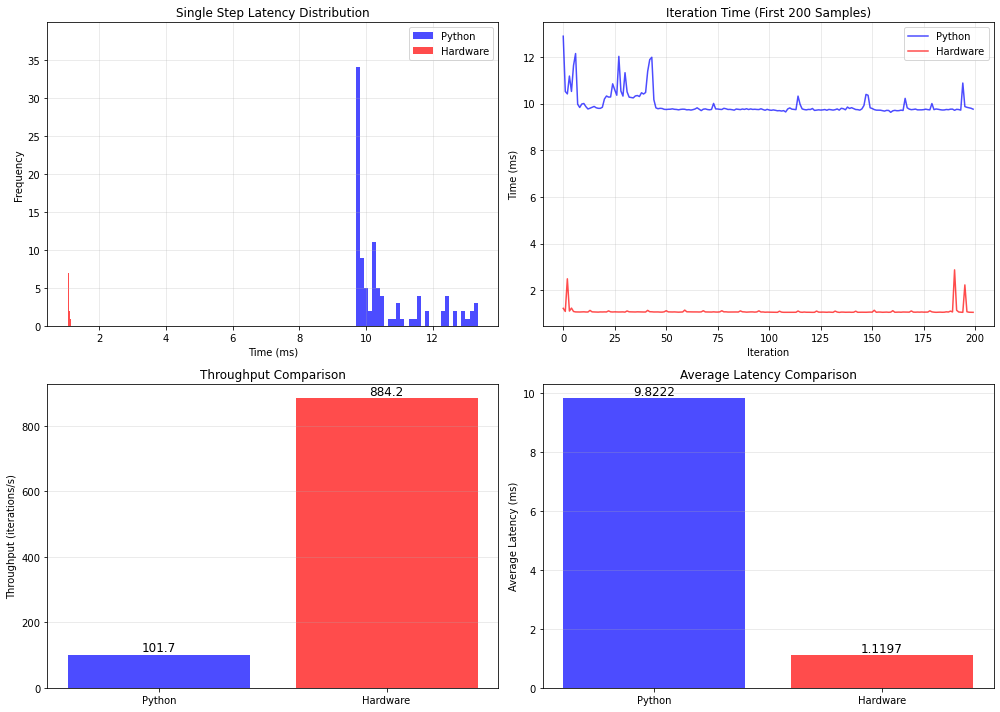


✓ 图表已保存为 lm_single_step_benchmark.png


In [31]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. 单步延迟分布
ax1 = axes[0, 0]
ax1.hist(py_times, bins=30, alpha=0.7, label='Python', color='blue')
if HW_AVAILABLE and hw_times is not None:
    ax1.hist(hw_times, bins=30, alpha=0.7, label='Hardware', color='red')
ax1.set_xlabel('Time (ms)')
ax1.set_ylabel('Frequency')
ax1.set_title('Single Step Latency Distribution')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. 迭代时间变化
ax2 = axes[0, 1]
ax2.plot(py_iter_times[:200], label='Python', alpha=0.7, color='blue')
if HW_AVAILABLE and hw_iter_times is not None:
    ax2.plot(hw_iter_times[:200], label='Hardware', alpha=0.7, color='red')
ax2.set_xlabel('Iteration')
ax2.set_ylabel('Time (ms)')
ax2.set_title('Iteration Time (First 200 Samples)')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. 吞吐量对比 (柱状图)
ax3 = axes[1, 0]
solvers = ['Python']
throughputs = [py_throughput]
colors = ['blue']
if HW_AVAILABLE:
    solvers.append('Hardware')
    throughputs.append(hw_throughput)
    colors.append('red')
bars = ax3.bar(solvers, throughputs, color=colors, alpha=0.7)
ax3.set_ylabel('Throughput (iterations/s)')
ax3.set_title('Throughput Comparison')
ax3.grid(True, alpha=0.3, axis='y')
# 添加数值标签
for bar, val in zip(bars, throughputs):
    ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height(), 
             f'{val:.1f}', ha='center', va='bottom', fontsize=12)

# 4. 平均延迟对比
ax4 = axes[1, 1]
avg_latencies = [np.mean(py_iter_times)]
labels = ['Python']
colors = ['blue']
if HW_AVAILABLE and hw_iter_times is not None:
    avg_latencies.append(np.mean(hw_iter_times))
    labels.append('Hardware')
    colors.append('red')
bars = ax4.bar(labels, avg_latencies, color=colors, alpha=0.7)
ax4.set_ylabel('Average Latency (ms)')
ax4.set_title('Average Latency Comparison')
ax4.grid(True, alpha=0.3, axis='y')
# 添加数值标签
for bar, val in zip(bars, avg_latencies):
    ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height(), 
             f'{val:.4f}', ha='center', va='bottom', fontsize=12)

plt.tight_layout()
plt.savefig('lm_single_step_benchmark.png', dpi=150)
plt.show()

print("\n✓ 图表已保存为 lm_single_step_benchmark.png")

## 9. 性能总结

In [32]:
print("="*70)
print(" "*20 + "LM 单步迭代性能总结")
print("="*70)

print(f"\n{'指标':<25} {'Python':<20} {'Hardware':<20}")
print("-"*65)

print(f"{'单步平均延迟 (ms)':<25} {np.mean(py_times):<20.4f}", end="")
if HW_AVAILABLE and hw_times:
    print(f"{np.mean(hw_times):<20.4f}")
else:
    print("N/A")

print(f"{'单步最小延迟 (ms)':<25} {np.min(py_times):<20.4f}", end="")
if HW_AVAILABLE and hw_times:
    print(f"{np.min(hw_times):<20.4f}")
else:
    print("N/A")

print(f"{'1000次总耗时 (s)':<25} {py_total:<20.4f}", end="")
if HW_AVAILABLE:
    print(f"{hw_total:<20.4f}")
else:
    print("N/A")

print(f"{'吞吐量 (iter/s)':<25} {py_throughput:<20.2f}", end="")
if HW_AVAILABLE:
    print(f"{hw_throughput:<20.2f}")
else:
    print("N/A")

print("-"*65)

if HW_AVAILABLE:
    speedup = np.mean(py_times) / np.mean(hw_times) if np.mean(hw_times) > 0 else 0
    print(f"\n⚡ 硬件加速比: {speedup:.2f}x")
    
    if errors:  = [-0.37637964  1.3521429   0.6959818   0.29597545 -1.031944  ]
  sin(q) = [-0.36755595  0.97619045  0.6411392   0.29167303 -0.8582982 ]
  cos(q) = [0.93000144 0.21691528 0.7674246  0.
        print(f"📊 数值精度: 平均差异 {np.mean(errors):.2e}, 最大差异 {np.max(max_errors):.2e}")
else:
    print("\n⚠ 硬件不可用，无法计算加速比")

print("\n" + "="*70)

                    LM 单步迭代性能总结

指标                        Python               Hardware            
-----------------------------------------------------------------
单步平均延迟 (ms)               10.6116             1.0748              
单步最小延迟 (ms)               9.6921              1.0541              
1000次总耗时 (s)              9.8359              1.1310              
吞吐量 (iter/s)              101.67              884.17              
-----------------------------------------------------------------

⚡ 硬件加速比: 9.87x
📊 数值精度: 平均差异 2.03e-08, 最大差异 5.07e-07



## 10. 额外测试: 不同输入规模的性能曲线

测试不同迭代次数下的性能...
  10 iterations: Python=106.55ms, HW=10.86ms
  50 iterations: Python=496.57ms, HW=53.92ms
  100 iterations: Python=991.01ms, HW=107.71ms
  200 iterations: Python=1957.07ms, HW=214.94ms
  500 iterations: Python=4883.78ms, HW=561.88ms
  1000 iterations: Python=9807.17ms, HW=1077.72ms


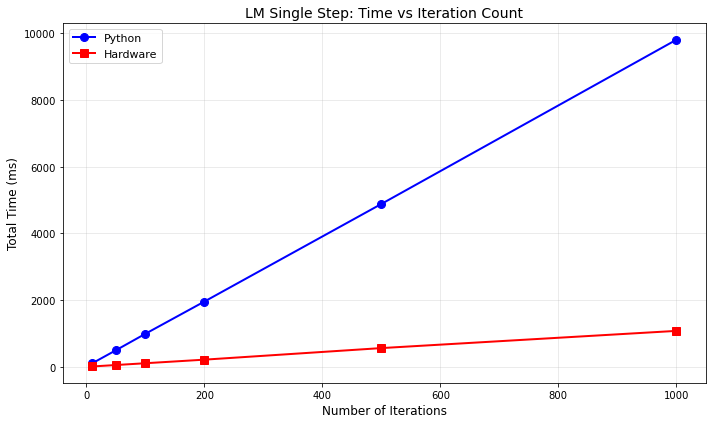


✓ 性能曲线图已保存为 lm_scaling_benchmark.png


In [11]:
# 测试不同迭代次数下的性能
iteration_counts = [10, 50, 100, 200, 500, 1000]
py_times_by_count = []
hw_times_by_count = []

print("测试不同迭代次数下的性能...")

for count in iteration_counts:
    # Python
    start = time.perf_counter()
    for sample in test_data[:count]:
        py_solver.solve_step(
            sample['sin_q'],
            sample['cos_q'],
            sample['error'],
            sample['lambda']
        )
    py_time = time.perf_counter() - start
    py_times_by_count.append(py_time * 1000)  # ms
    
    # Hardware
    if HW_AVAILABLE:
        start = time.perf_counter()
        for sample in test_data[:count]:
            hw_iterator.solve_step(
                sample['q'],
                sample['error'],
                sample['lambda']
            )
        hw_time = time.perf_counter() - start
        hw_times_by_count.append(hw_time * 1000)
    
    print(f"  {count} iterations: Python={py_time*1000:.2f}ms", end="")
    if HW_AVAILABLE:
        print(f", HW={hw_time*1000:.2f}ms")
    else:
        print()

# 绘制性能曲线
plt.figure(figsize=(10, 6))
plt.plot(iteration_counts, py_times_by_count, 'b-o', label='Python', linewidth=2, markersize=8)
if HW_AVAILABLE:
    plt.plot(iteration_counts, hw_times_by_count, 'r-s', label='Hardware', linewidth=2, markersize=8)
plt.xlabel('Number of Iterations', fontsize=12)
plt.ylabel('Total Time (ms)', fontsize=12)
plt.title('LM Single Step: Time vs Iteration Count', fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('lm_scaling_benchmark.png', dpi=150)
plt.show()

print("\n✓ 性能曲线图已保存为 lm_scaling_benchmark.png")